In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *

%matplotlib notebook

# Load data

In [2]:
path = '/Users/blandt/Desktop/Analysis/Experiments/e1908__optogenetics'
direcs = direcslist(path, 2)

imgs = [load_image(glob.glob(d + '/*561 SP 630-75*')[0]) for d in direcs]
rois = [spline_roi(np.loadtxt(d + '/ROI.txt'), periodic=True) for d in direcs]
imgs_subtracted = [bg_subtraction(i, r) for i, r in zip(imgs, rois)]

cytbg = np.loadtxt('../Cytoplasmic reference/cytbg.txt')
membg = np.loadtxt('membg.txt')

cytbg = cytbg / max(cytbg)
membg = membg / max(membg)

<IPython.core.display.Javascript object>


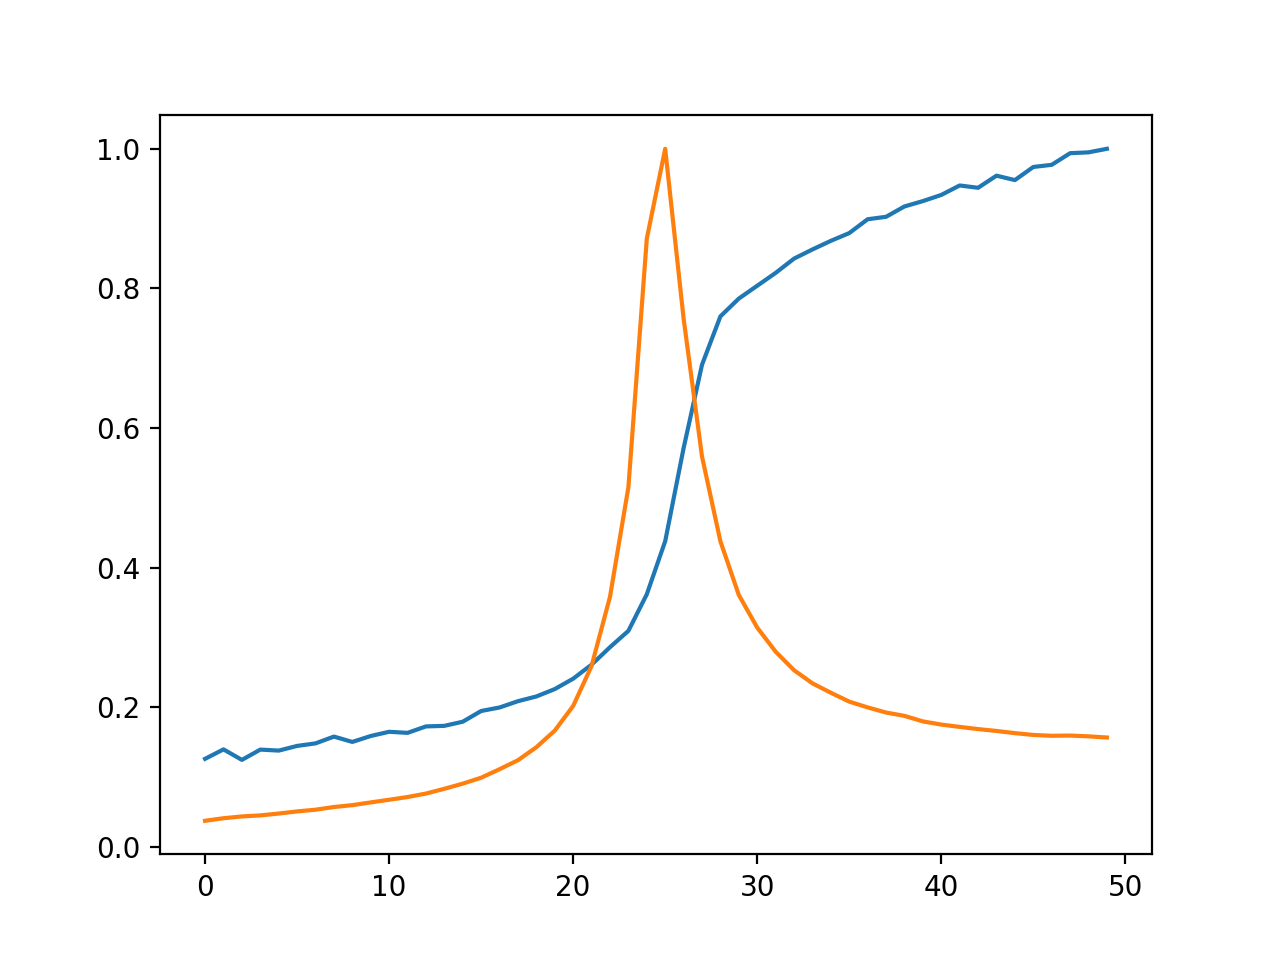

In [11]:
fig, ax = plt.subplots()
ax.plot(cytbg)
ax.plot(membg)

# Run quantification

In [4]:
iq = ImageQuant(imgs_subtracted, roi=rois, iterations=2, thickness=50, cytbg=cytbg, membg=membg, 
                descent_steps=200, uni_cyt=True, nfits=100, interp_type='linear')

In [5]:
iq.run()

100%|██████████| 200/200 [01:16<00:00,  2.60it/s]


Time elapsed: 157.77 seconds 


<IPython.core.display.Javascript object>


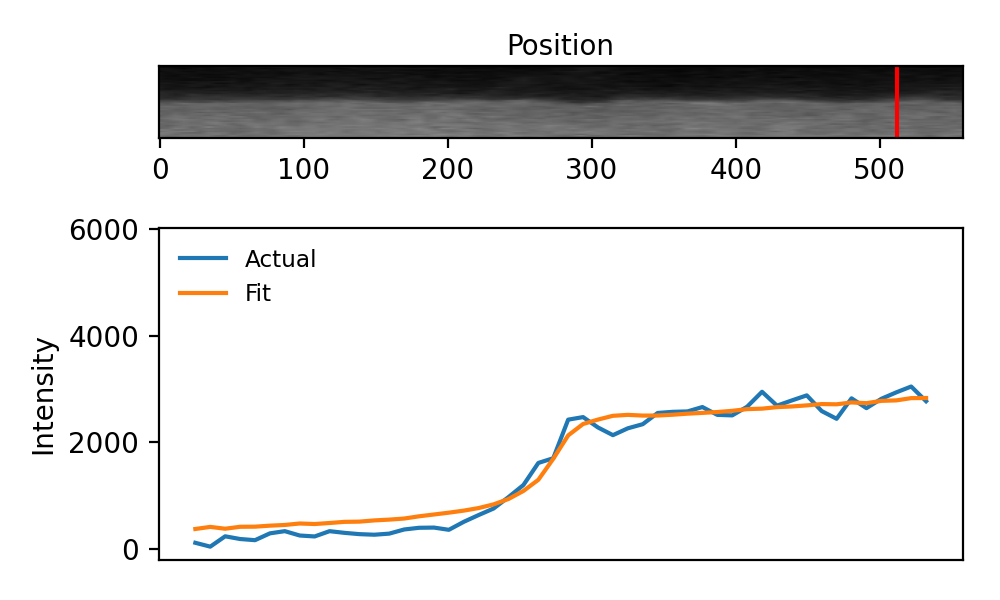

interactive(children=(IntSlider(value=0, description='Frame', max=146), FloatSlider(value=0.1, description='Po…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [12]:
iq.plot_fits(jupyter=True)

# Results dataframe

In [13]:
res = iq.compile_res()
res.to_csv('optogenetics_res.csv')

# Conditions dataframe

In [14]:
df = pd.DataFrame()
for i, d in enumerate(direcs):
    p = {}
    p['Frame'] = i
    p['Path'] = d
    p['Embryo'] = d.split('/')[-2]
    p['Timepoint'] = d.split('/')[-1]
    p['Line'] = d.split('/')[-3].split('_')[1]
    df = df.append(pd.DataFrame(p, index=[i]))
    
df.to_csv('optogenetics_df.csv')
print(df)

     Frame                                               Path Embryo  \
0        0  /Users/blandt/Desktop/Analysis/Experiments/e19...     E1   
1        1  /Users/blandt/Desktop/Analysis/Experiments/e19...     E1   
2        2  /Users/blandt/Desktop/Analysis/Experiments/e19...     E1   
3        3  /Users/blandt/Desktop/Analysis/Experiments/e19...     E1   
4        4  /Users/blandt/Desktop/Analysis/Experiments/e19...     E1   
..     ...                                                ...    ...   
142    142  /Users/blandt/Desktop/Analysis/Experiments/e19...     E5   
143    143  /Users/blandt/Desktop/Analysis/Experiments/e19...     E5   
144    144  /Users/blandt/Desktop/Analysis/Experiments/e19...     E5   
145    145  /Users/blandt/Desktop/Analysis/Experiments/e19...     E5   
146    146  /Users/blandt/Desktop/Analysis/Experiments/e19...     E5   

    Timepoint    Line  
0          01  nwg206  
1          02  nwg206  
2          03  nwg206  
3          04  nwg206  
4          05  

# Perform calibration

Getting lots of negative concentrations for some reason. I think it's unreasonable to use the same background curves for cherry fluorophores, and background subtraction not working properly - seems like background is non-uniform. Could do by fitting a non-uniform backgound parameter.

Best solution: do calibration with pre and post-symmetry breaking embryos

In [15]:
res = pd.read_csv('optogenetics_res.csv')
df = pd.read_csv('optogenetics_df.csv')

In [16]:
svr = 0.157

df_sv2061 = df[df.Line == 'sv2061']
res_sv2061 = res[res.Frame.isin(df_sv2061.Frame)]
res_sv2061_grouped = res_sv2061.sort_values('Position').groupby('Frame')
mems = res_sv2061_grouped.apply(lambda x: np.mean(x['Membrane signal']))
cyts = res_sv2061_grouped.apply(lambda x: np.mean(x['Cytoplasmic signal']))

grouped = df_sv2061.groupby('Embryo')
mems_pre = grouped.apply(lambda x: mems[x.Frame[x.Timepoint == 'Pre']]).to_numpy()
mems_post = grouped.apply(lambda x: mems[x.Frame[x.Timepoint == '01']]).to_numpy()
cyts_pre = grouped.apply(lambda x: cyts[x.Frame[x.Timepoint == 'Pre']]).to_numpy()
cyts_post = grouped.apply(lambda x: cyts[x.Frame[x.Timepoint == '01']]).to_numpy()
c = ((cyts_pre - cyts_post) / (mems_post - mems_pre)) / svr

print(c)
print(np.mean(c))

[3.32442085 3.58452722 3.85238636 3.64394066]
3.601318771039531
